In [1]:
from __future__ import division

from IPython.display import display

from glob import glob
import matplotlib.pyplot as plt
from scipy import stats
from biom import load_table
from biom.table import Table
from biom.exception import UnknownIDError
import numpy as np
import pandas as pd
import time
import os
import seaborn as sns
import warnings

%matplotlib inline

In [2]:
# read in metadata
meta = pd.read_table("../data/797_prep_296_qiime_20150818-225202.txt", index_col=0)
meta = meta.sort_index()

# get rid of dogs
meta = meta[meta.host_common_name=="human"]

# read in biom table
table = load_table("/Users/shafferm/lab/sourcetracker/153_otu_table.biom")

# get rid of samples with < 1000 reads
table.filter(table.ids()[table.sum(axis="sample") > 1000])

# match samples in both table and metadata
in_both = set(table.ids()) & set(meta.index)
table.filter(in_both)
meta = meta.loc[list(in_both)]

# get only samples which have all 5 samples (2 palms, forehead, tongue, stool)
all_samples_names = [i for i in set(meta.anonymized_name) if meta.loc[meta.anonymized_name==i].shape[0] == 5]
all_samples_samples = [i for i in meta.index if meta.loc[i, "anonymized_name"] in all_samples_names]
table.filter(all_samples_samples)
meta = meta.loc[all_samples_samples]

print table.shape
print meta.shape

all_palms = np.array([i for i in meta.index if 'palm' in i.lower()])

(15974, 700)
(700, 64)


In [5]:
# read in all sink predictions and make mega dataframe
sink_predictions = []
folders = glob('../results/*')
for folder in folders:
    sink_pred = pd.read_table(folder+'/sink_predictions.txt', index_col=0)
    sink_predictions.append(sink_pred)

palm_sink_predictions = pd.concat(sink_predictions)
palm_sink_predictions = palm_sink_predictions.sort_index()

# define sources
sources = ['skin', 'Stool', 'tongue', 'Unknown']

# categorize by site
all_palm_df = palm_sink_predictions.groupby([i.split('.')[-1] if len(i.split('.')) > 1 else i for i in palm_sink_predictions.columns], axis=1).sum()
all_palm_df = all_palm_df.loc[[i for i in all_palm_df.index if i in all_samples_samples]]

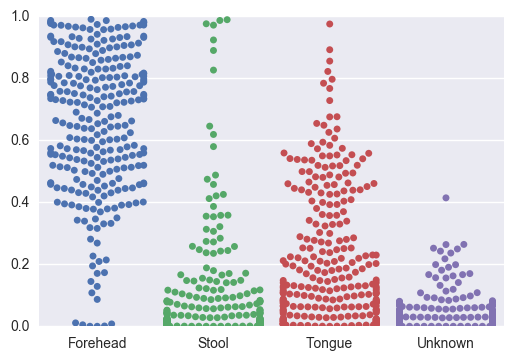

In [8]:
ax = sns.swarmplot(data=all_palm_df)
_ = ax.set_ylim((0,1))

In [9]:
min_percent_df = pd.DataFrame(index=["Forehead", "Stool", "Tongue"])
min_percents = [.0001, .001, .01, .1, .2, .3, .4]
for i in min_percents:
    min_percent_df[i] = (all_palm_df < i).sum(axis=0)
display(min_percent_df)

,0.0001,0.001,0.01,0.1,0.2,0.3,0.4
Forehead,1,3,5,7,13,18,38
Stool,2,14,115,216,240,250,258
Tongue,1,5,27,111,162,194,209


In [10]:
def pick_palms(series, min_percent, num_samples=20):
    # only want to pick samples with very low starting amounts of given series
    series = series[series<min_percent]
    if series.shape[0] < num_samples:
        warnings.warn("Less samples below min percent than requested, returning all samples below threshold")
        return list(series.index)
    rand_indicies = list()
    while len(set(rand_indicies)) != num_samples:
        rand_indicies = np.random.randint(0, series.shape[0], num_samples)
    return list(series.index[rand_indicies])

def spikein(row, spike, proportion):
    # figure out how many reads to add to achieve a given proportion of reads from spikein row
    row_sum = np.sum(row)
    amount_to_add = (row_sum/(1-proportion))-row_sum

    # randomly select amount_to_add reads to add to row
    to_add = np.zeros(row.shape)
    cumsum = np.cumsum(spike)
    rand_indicies = np.random.randint(0, spike.sum(), amount_to_add)
    for i in rand_indicies:
        to_add_index = (cumsum <=  i).sum()
        to_add[to_add_index] += 1    
    return row + to_add

def make_spiked_table(palms, table, out_site='Stool', reps=3):
    proportions = list(np.linspace(.1, .9, 9))
    spiked_rows = list()
    spiked_row_names = list()
    for palm in palms:
        palm_row = table.data(palm)
        stool_name = '.'.join(palm.split('.')[:-1] + [out_site])
        stool_row = table.data(stool_name)
        for i in xrange(reps):
            for proportion in proportions:
                spiked_row = spikein(palm_row, stool_row, proportion)
                spiked_rows.append(spiked_row)
                spiked_row_name = "%s_%s_%d" % (palm, str(proportion), i)
                spiked_row_names.append(spiked_row_name)
    spiked_data = np.vstack(spiked_rows)
    spiked_table = Table(spiked_data.transpose(), table.ids(axis="observation"), spiked_row_names)
    new_table = table.merge(spiked_table)
    new_table = new_table.subsample(1000)
    return new_table

def make_spiked_table_out(palms, table, out_site, out_inds, reps=3):
    proportions = list(np.linspace(.1, .9, 9))
    spiked_rows = list()
    spiked_row_names = list()
    for palm in palms:
        palm_row = table.data(palm)
        stool_name = '.'.join(palm.split('.')[:-1] + [out_site])
        out_name = stool_name
        while stool_name == out_name:
            out_name = out_inds[np.random.randint(0, len(out_inds))]
        stool_row = table.data(out_name)
        for i in xrange(reps):
            for proportion in proportions:
                spiked_row = spikein(palm_row, stool_row, proportion)
                spiked_rows.append(spiked_row)
                spiked_row_name = "%s_%s_%s_%d" % (palm, out_name, str(proportion), i)
                spiked_row_names.append(spiked_row_name)
    spiked_data = np.vstack(spiked_rows)
    spiked_table = Table(spiked_data.transpose(), table.ids(axis="observation"), spiked_row_names)
    new_table = table.merge(spiked_table)
    new_table = new_table.subsample(1000)
    return new_table

def make_mapping_files(spiked_table, meta):
    # make mapping files
    sink_rows = list()
    source_rows = list()
    for i in spiked_table.ids():
        if i not in meta.index:
            sink_rows.append([i, "sink", "sink"])
        else:
            if "palm" not in i.lower():
                source_rows.append([i, "source", i])

    columns = ["#SampleID", "SourceSink", "Env"]
    source_mapping = pd.DataFrame(source_rows, columns=columns)
    mapping_files = list()
    for row in sink_rows:
        mapping = source_mapping.copy()
        mapping.loc[mapping.shape[0]] = row
        mapping_files.append(mapping)
    return mapping_files

In [11]:
stool_palms = pick_palms(all_palm_df.Stool, .01, 20)
stool_spiked_table = make_spiked_table(stool_palms, table)
stool_mapping_files = make_mapping_files(stool_spiked_table, meta)

/Users/shafferm/miniconda2/envs/sourcetracker/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
stool_time = time.strftime("%Y%m%d%H%M%S")
print stool_time
with open("min_percent/spiked_table_stool_%s.biom" % stool_time, 'w') as f:
    f.write(stool_spiked_table.to_tsv())
stool_mapping_dir = "min_percent/spiked_mapping_stool_%s/" % stool_time
os.mkdir(stool_mapping_dir)
for i, mapping in enumerate(stool_mapping_files):
    mapping.to_csv(stool_mapping_dir+"spiked_mapping_%d.txt" % i, sep='\t', index=False)

In [8]:
outstool_palms = pick_palms(all_palm_df.Stool, .01, 20)
stool_samples = list(meta.loc[meta.env=='stool'].index)
outstool_spiked_table = make_spiked_table_out(outstool_palms, table, 'Stool', stool_samples)
outstool_mapping_files = make_mapping_files(outstool_spiked_table, meta)

/Users/shafferm/miniconda2/envs/sourcetracker/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [9]:
outstool_time = time.strftime("%Y%m%d%H%M%S")
print outstool_time
with open("min_percent/spiked_table_outstool_%s.biom" % outstool_time, 'w') as f:
    f.write(outstool_spiked_table.to_tsv())
outstool_mapping_dir = "min_percent/spiked_mapping_outstool_%s/" % outstool_time
os.mkdir(outstool_mapping_dir)
for i, mapping in enumerate(outstool_mapping_files):
    mapping.to_csv(outstool_mapping_dir+"spiked_mapping_%d.txt" % i, sep='\t', index=False)

In [11]:
forehead_palms = pick_palms(all_palm_df.Forehead, .01, 20)
forehead_spiked_table = make_spiked_table(forehead_palms, table, out_site="Forehead")
forehead_mapping_files = make_mapping_files(forehead_spiked_table, meta)

/Users/shafferm/miniconda2/envs/sourcetracker/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Less samples below min percent than requested, returning all samples below threshold
/Users/shafferm/miniconda2/envs/sourcetracker/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [12]:
forehead_time = time.strftime("%Y%m%d%H%M%S")
print forehead_time
with open("min_percent/spiked_table_forehead_%s.biom" % forehead_time, 'w') as f:
    f.write(forehead_spiked_table.to_tsv())
forehead_mapping_dir = "min_percent/spiked_mapping_forehead_%s/" % forehead_time
os.mkdir(forehead_mapping_dir)
for i, mapping in enumerate(forehead_mapping_files):
    mapping.to_csv(forehead_mapping_dir+"spiked_mapping_%d.txt" % i, sep='\t', index=False)

In [7]:
tongue_palms = pick_palms(all_palm_df.Tongue, .01, 20)
tongue_spiked_table = make_spiked_table(tongue_palms, table, out_site="Tongue")
tongue_mapping_files = make_mapping_files(tongue_spiked_table, meta)

/Users/shafferm/miniconda2/envs/sourcetracker/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
tongue_time = time.strftime("%Y%m%d%H%M%S")
print tongue_time
with open("min_percent/spiked_table_tongue_%s.biom" % tongue_time, 'w') as f:
    f.write(tongue_spiked_table.to_tsv())
tongue_mapping_dir = "min_percent/spiked_mapping_tongue_%s/" % tongue_time
os.mkdir(tongue_mapping_dir)
for i, mapping in enumerate(tongue_mapping_files):
    mapping.to_csv(tongue_mapping_dir+"spiked_mapping_%d.txt" % i, sep='\t', index=False)